In [60]:
import numpy as np
import pandas as pd
import env
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [61]:
def get_connection(db: str, user: str = env.user, host: str = env.host, password=env.password) -> str:
    return f"mysql+pymysql://{user}:{password}@{host}/{db}"

In [62]:
def get_store_data(file_name="store.csv") -> pd.DataFrame:
    if os.path.isfile(file_name):
        return pd.read_csv(file_name)
    query = """SELECT *
            FROM items
            JOIN sales USING(item_id)
            JOIN stores USING(store_id)
            """
    connection = get_connection("tsa_item_demand")
    df = pd.read_sql(query, connection)
    df.to_csv(file_name, index=False)
    return df

In [63]:
df = get_store_data()
df.head()

,store_id,item_id,item_upc14,item_upc12,item_brand,item_name,item_price,sale_id,sale_date,sale_amount,store_address,store_zipcode,store_city,store_state
0,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,1,2013-01-01,13,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
1,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,2,2013-01-02,11,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
2,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,3,2013-01-03,14,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
3,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,4,2013-01-04,13,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
4,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,5,2013-01-05,10,12125 Alamo Ranch Pkwy,78253,San Antonio,TX


In [64]:
df.sale_date

0         2013-01-01
1         2013-01-02
2         2013-01-03
3         2013-01-04
4         2013-01-05
             ...    
912995    2017-12-27
912996    2017-12-28
912997    2017-12-29
912998    2017-12-30
912999    2017-12-31
Name: sale_date, Length: 913000, dtype: object

In [65]:
def prepare_store(df):
    # convert the sale date into a datetime
    df.sale_date = pd.to_datetime(df.sale_date)
    # set the index as the new datetime value
    df = df.set_index('sale_date')
    #extract the month value (name of month)
    df['month'] = df.index.strftime('%B')
    # extract the day of the week from the date
    df['day of the week'] = df.index.day_name()
    # calculate the total sales
    df['sales_total'] = df.sale_amount * df.item_price
    return df

In [66]:
df = prepare_store(df)
df.head()

,store_id,item_id,item_upc14,item_upc12,item_brand,item_name,item_price,sale_id,sale_amount,store_address,store_zipcode,store_city,store_state,month,day of the week,sales_total
sale_date,,,,,,,,,,,,,,,,
2013-01-01,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,1,13,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,January,Tuesday,10.92
2013-01-02,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,2,11,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,January,Wednesday,9.24
2013-01-03,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,3,14,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,January,Thursday,11.76
2013-01-04,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,4,13,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,January,Friday,10.92
2013-01-05,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,5,10,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,January,Saturday,8.40


# Split

In [67]:
train_size = .70
n = df.shape[0]
test_start_index = round(train_size * n)

train = df[:test_start_index] # everything up (not including) to the test_start_index
test = df[test_start_index:] # everything from the test_start_index to the end


# Visualization
- Target Variable 

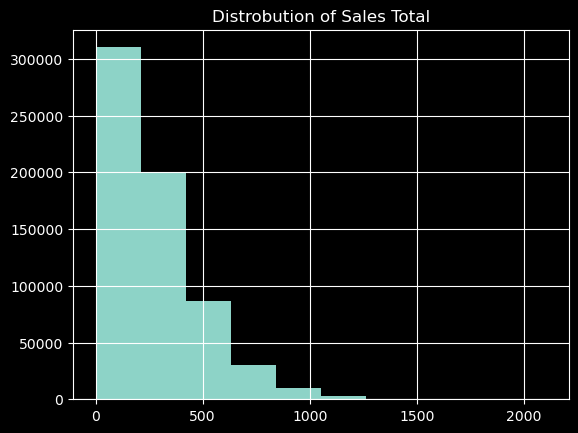

In [68]:
# we just have a single thing here: temperature
# so lets see how the temperatures are distributed
# independent of the dates they are attached to
train.sales_total.hist()
plt.title('Distrobution of Sales Total')
plt.show()

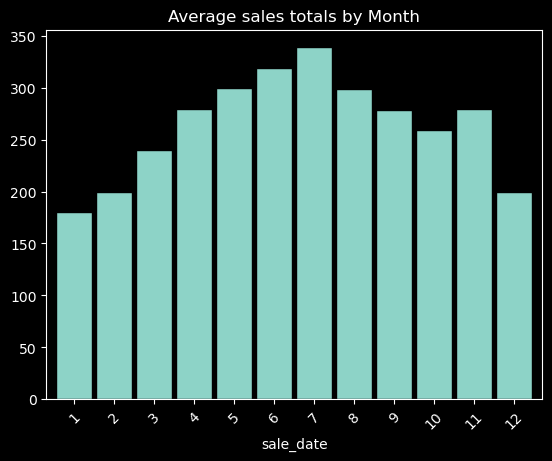

In [69]:
y = train['sales_total']

ax = y.groupby(y.index.month).mean().plot.bar(width=0.9, ec='black')
ax.set_title('Average sales totals by Month')
plt.xticks(rotation=45)
plt.show()


In [70]:
y.groupby(y.index.day_of_week).mean()

sale_date
0    209.935112
1    244.277538
2    245.068830
3    262.014787
4    279.175355
5    297.183647
6    314.703583
Name: sales_total, dtype: float64

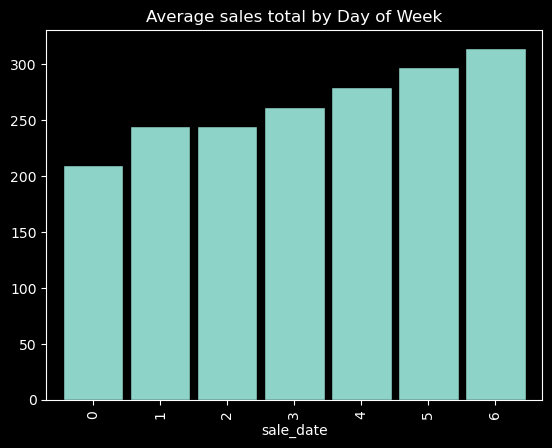

In [71]:
ax = y.groupby(
    y.index.day_of_week).mean().plot.bar(width=0.9, ec='black')

ax.set_title('Average sales total by Day of Week')
# ax.set(xlabels=y.index.day_name().unique().to_list())
plt.show()

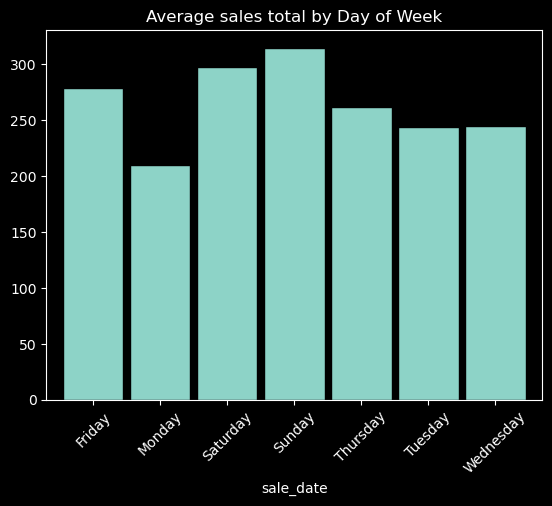

In [72]:
ax = y.groupby(y.index.day_name()).mean().plot.bar(width=0.9, ec='black')
ax.set_title('Average sales total by Day of Week')
plt.xticks(rotation=45)
plt.show()

In [73]:
train['day_of_week'] = train.index.day_name()

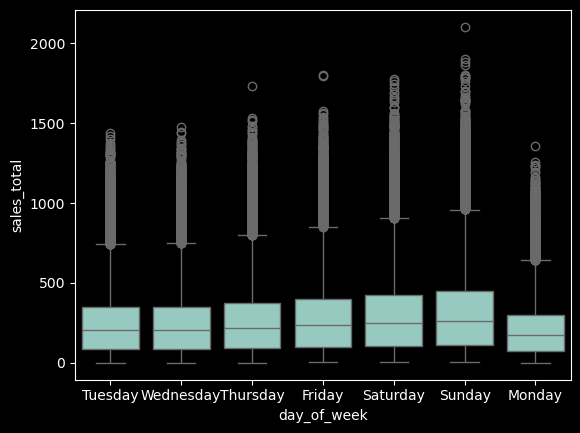

In [74]:
sns.boxplot(
    data=train,
x='day_of_week',
y='sales_total')
plt.show()

<Axes: xlabel='sale_date'>

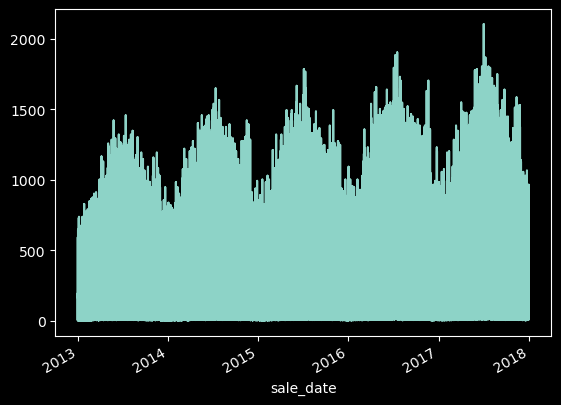

In [75]:
y.plot()

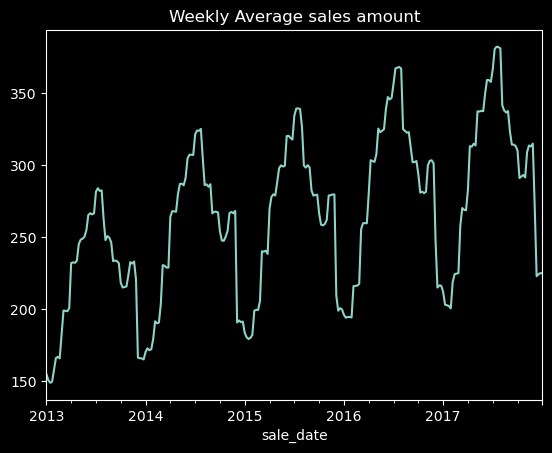

In [78]:
y.resample('1W').mean().plot(title='Weekly Average sales amount')
plt.show()

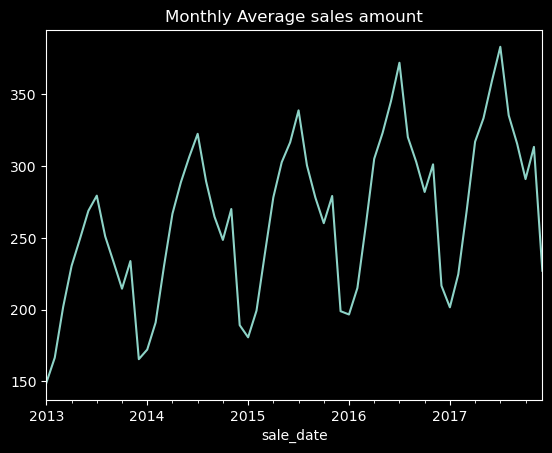

In [79]:
y.resample('1M').mean().plot(title='Monthly Average sales amount')
plt.show()

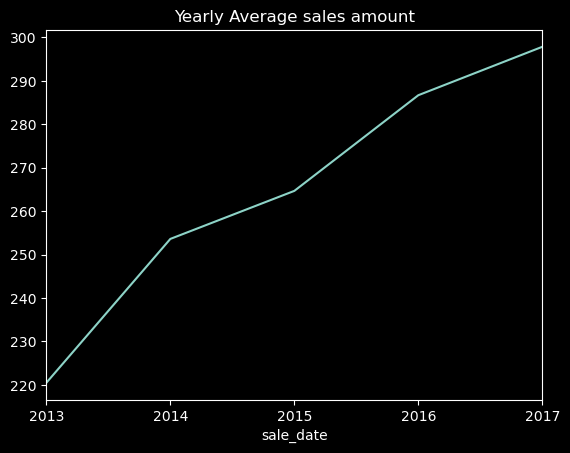

In [80]:
y.resample('1Y').mean().plot(title='Yearly Average sales amount')
plt.show()

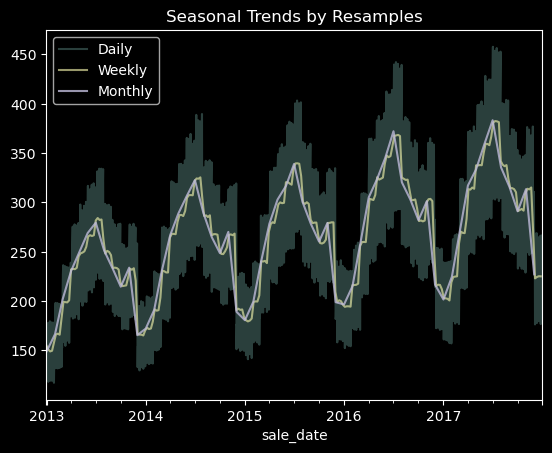

In [81]:
y.resample('1D').mean().plot(label='Daily', alpha=0.3)
y.resample('1W').mean().plot(label='Weekly', alpha=0.6)
y.resample('1M').mean().plot(label='Monthly', alpha=0.8)
# y.resample('1Y').mean().plot(label='Yearly')
plt.legend()
plt.title('Seasonal Trends by Resamples')
plt.show()

# With Lag

In [82]:
pd.concat([y.resample('W').mean(),y.resample('W').mean().diff()], axis=1)


,sales_total,sales_total
sale_date,,
2013-01-06,155.095957,NaN
2013-01-13,150.924914,-4.171043
2013-01-20,148.959927,-1.964988
2013-01-27,149.666343,0.706416
2013-02-03,157.938482,8.272139
...,...,...
2017-12-03,271.326629,-43.758576
2017-12-10,222.976061,-48.350567
2017-12-17,224.396612,1.420551


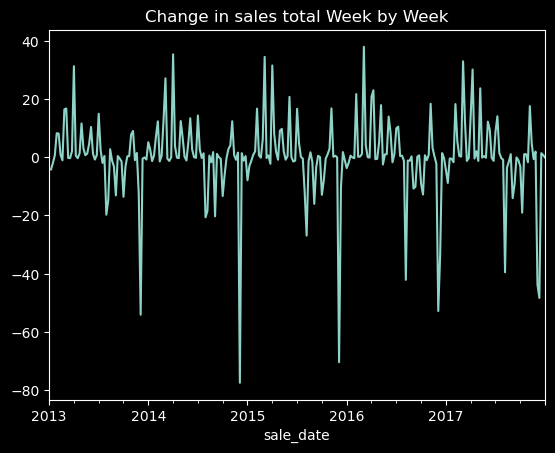

In [83]:
y.resample('W').mean().diff().plot()
plt.title('Change in sales total Week by Week')
plt.show()

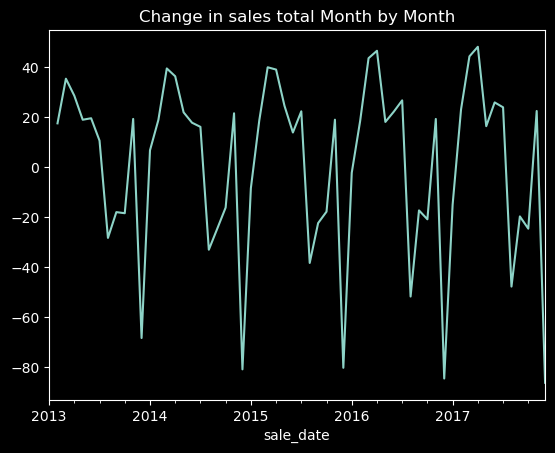

In [84]:
y.resample('M').mean().diff().plot()
plt.title('Change in sales total Month by Month')
plt.show()

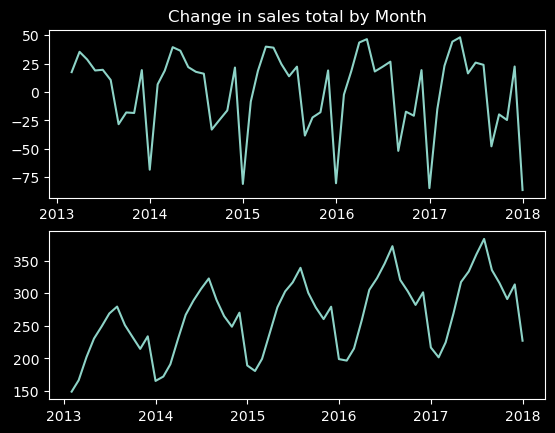

In [85]:
# lets compare the diff in months with the average month
# set up a subplots call:
fig, axs = plt.subplots(2,1)
axs[0].plot(y.resample('M').mean().diff())
axs[0].set_title('Change in sales total by Month')
axs[1].plot(y.resample('M').mean())
plt.show()

In [86]:
y.groupby([y.index.year, y.index.month]).mean()[:3]

sale_date  sale_date
2013       1            148.969171
           2            166.461881
           3            201.823634
Name: sales_total, dtype: float64

In [87]:
# pivoting out a two layer index:
# df.unstack()
y.groupby([y.index.year, y.index.month]).mean().unstack(0)

sale_date,2013,2014,2015,2016,2017
sale_date,,,,,
1,148.969171,172.120098,180.653196,196.578106,201.570813
2,166.461881,190.999758,199.273398,215.035779,224.609216
3,201.823634,230.466550,239.208213,258.601254,268.912034
4,230.380267,266.795686,278.224458,305.134885,317.046086
5,249.316675,288.693895,302.733241,323.197924,333.410822
6,268.850218,306.441082,316.567217,345.353774,359.282229
7,279.415909,322.528984,338.880997,372.050096,383.194429
8,251.061858,289.448286,300.514469,320.236287,335.369188
9,233.027362,264.766299,278.085684,302.897543,315.623887


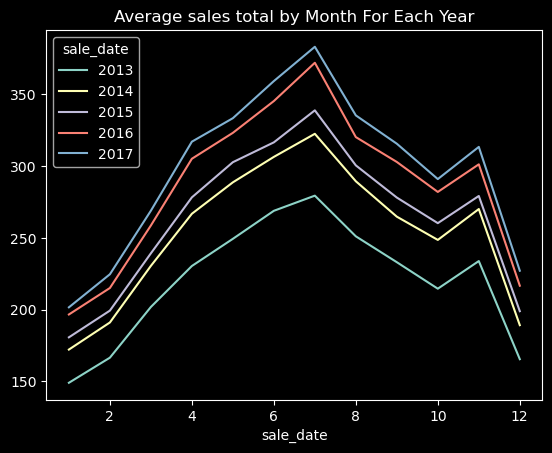

In [88]:
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot()
plt.title('Average sales total by Month For Each Year')
plt.show()

In [89]:
table = y.groupby([y.index.year, y.index.month]).mean().unstack(0)

In [90]:
table

sale_date,2013,2014,2015,2016,2017
sale_date,,,,,
1,148.969171,172.120098,180.653196,196.578106,201.570813
2,166.461881,190.999758,199.273398,215.035779,224.609216
3,201.823634,230.466550,239.208213,258.601254,268.912034
4,230.380267,266.795686,278.224458,305.134885,317.046086
5,249.316675,288.693895,302.733241,323.197924,333.410822
6,268.850218,306.441082,316.567217,345.353774,359.282229
7,279.415909,322.528984,338.880997,372.050096,383.194429
8,251.061858,289.448286,300.514469,320.236287,335.369188
9,233.027362,264.766299,278.085684,302.897543,315.623887


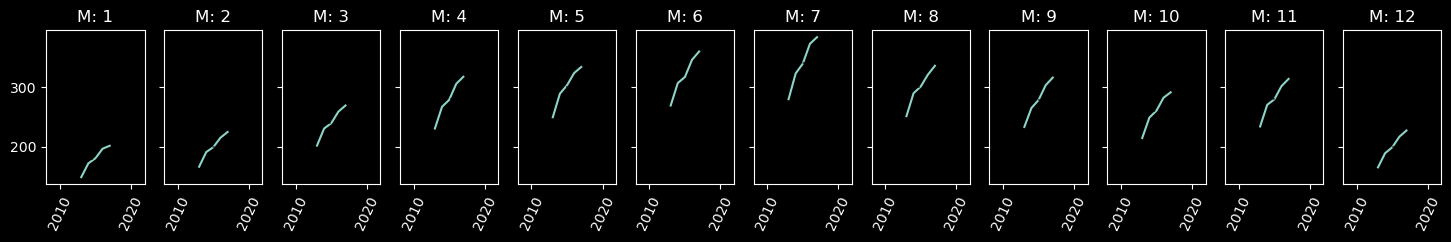

In [91]:
# lets use this table
# to examine how the years have changed the 
# temperature over a specific month:
# how does december look over time specifically?
# step one: create a subplots call
fig, axs = plt.subplots(1,12, sharey=True, sharex=True, figsize=(18,2))
# fig.suptitle('Months Throughout the Years')
for ax, (month, subset) in zip(axs, table.iterrows()):
    #plot the subset, do it specifically on that axis
    subset.plot(ax=ax)
    # we can also call the same thing with:
    # ax.plot(subset)
    # lets add a horizontal line
    # it goes from the beginning to the end of the x axis *ax.get_xlim()
    ax.set_title(f'M: {month}')
    ax.hlines(subset.mean(), 
              *ax.get_xlim(), 
              ls=':', 
              alpha=0.6, 
              color='black', )
    ax.set(xlabel='')
    ax.tick_params('x',rotation=65)

In [92]:
my_kwargs = {
    'hi': 10,
    'hello': 25
}

In [93]:
def my_fake_function(hi=0, hello=10):
    return (hi + hello)

In [94]:
my_fake_function(**my_kwargs)

35

In [95]:
pd.concat([y, y.shift(-1)], axis=1).tail()

,sales_total,sales_total
sale_date,,
2017-12-27,171.6,213.2
2017-12-28,213.2,228.8
2017-12-29,228.8,228.8
2017-12-30,228.8,239.2
2017-12-31,239.2,NaN


In [96]:
train.loc[:,'y(t+1)'] = train.sales_total.shift(-1).values

In [97]:
train.tail()

,store_id,item_id,item_upc14,item_upc12,item_brand,item_name,item_price,sale_id,sale_amount,store_address,store_zipcode,store_city,store_state,month,day of the week,sales_total,day_of_week,y(t+1)
sale_date,,,,,,,,,,,,,,,,,,
2017-12-27,7,50,47445919221,47445919221,Choice,Choice Organic Teas Black Tea Classic Black - ...,5.2,907518,33,12018 Perrin Beitel Rd,78217,San Antonio,TX,December,Wednesday,171.6,Wednesday,213.2
2017-12-28,7,50,47445919221,47445919221,Choice,Choice Organic Teas Black Tea Classic Black - ...,5.2,907519,41,12018 Perrin Beitel Rd,78217,San Antonio,TX,December,Thursday,213.2,Thursday,228.8
2017-12-29,7,50,47445919221,47445919221,Choice,Choice Organic Teas Black Tea Classic Black - ...,5.2,907520,44,12018 Perrin Beitel Rd,78217,San Antonio,TX,December,Friday,228.8,Friday,228.8
2017-12-30,7,50,47445919221,47445919221,Choice,Choice Organic Teas Black Tea Classic Black - ...,5.2,907521,44,12018 Perrin Beitel Rd,78217,San Antonio,TX,December,Saturday,228.8,Saturday,239.2
2017-12-31,7,50,47445919221,47445919221,Choice,Choice Organic Teas Black Tea Classic Black - ...,5.2,907522,46,12018 Perrin Beitel Rd,78217,San Antonio,TX,December,Sunday,239.2,Sunday,NaN


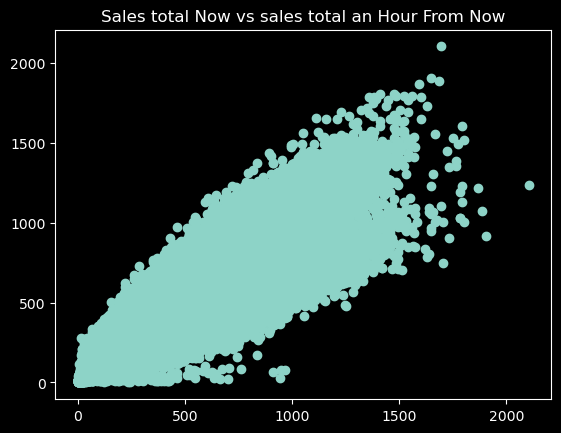

In [98]:
plt.scatter(train.sales_total, train['y(t+1)'])
plt.title('Sales total Now vs sales total an Hour From Now')
plt.show()

In [99]:
train = train.drop(columns=['day_of_week','y(t+1)'])

<Axes: xlabel='y(t)', ylabel='y(t + 52)'>

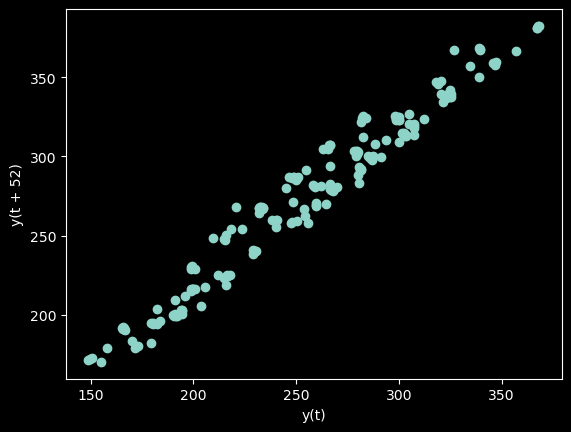

In [100]:
pd.plotting.lag_plot(train.sales_total.resample('W').mean(), 52)

# Autocorrelation

In [102]:
from scipy import stats

In [112]:
s = pd.Series(
    {
        lag: stats.pearsonr(
        train.sales_total.iloc[:-lag], train.sales_total.shift(-lag).dropna())[0]
        for lag in range(1,52 * 3)
    }
)

In [113]:
s

1      0.928697
2      0.916828
3      0.905986
4      0.905115
5      0.914250
         ...   
151    0.721168
152    0.729065
153    0.738853
154    0.765309
155    0.734989
Length: 155, dtype: float64

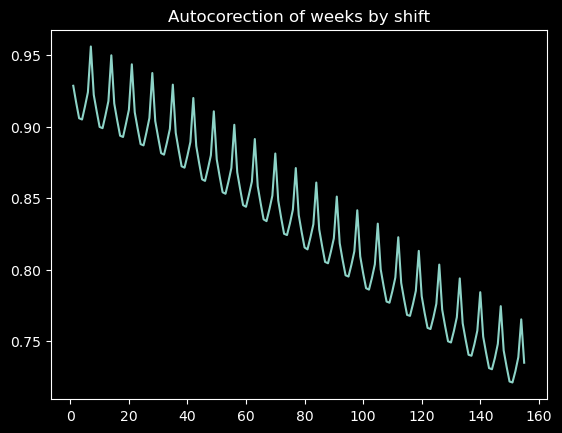

In [114]:
s.plot()
plt.title('Autocorection of weeks by shift')
plt.show()

# Decomposition

In [116]:
y = train.sales_total.resample('W').mean()

In [117]:
result = sm.tsa.seasonal_decompose(y)

In [118]:
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'residual': result.resid
})

In [119]:
decomposition

,y,trend,seasonal,residual
sale_date,,,,
2013-01-06,155.095957,NaN,-74.534329,NaN
2013-01-13,150.924914,NaN,-77.771949,NaN
2013-01-20,148.959927,NaN,-78.841579,NaN
2013-01-27,149.666343,NaN,-79.095950,NaN
2013-02-03,157.938482,NaN,-77.836930,NaN
...,...,...,...,...
2017-12-03,271.326629,NaN,-59.534839,NaN
2017-12-10,222.976061,NaN,-70.643397,NaN
2017-12-17,224.396612,NaN,-70.587182,NaN


<Axes: xlabel='sale_date'>

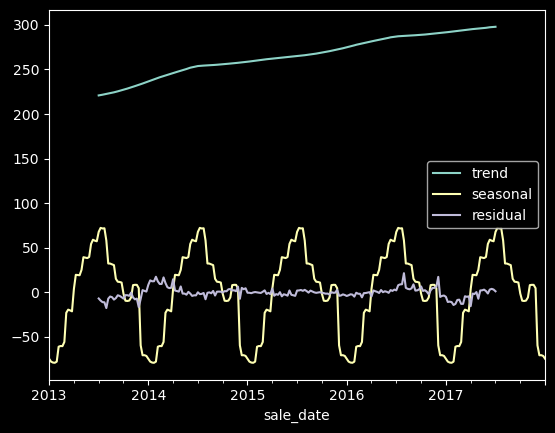

In [120]:
decomposition[['trend', 'seasonal', 'residual']].plot()


# Energy Data 

In [ ]:
OPSD = pd.read_csv('https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv')
OPSD.head()

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.184,NaN,NaN,NaN
1,2006-01-02,1380.521,NaN,NaN,NaN
2,2006-01-03,1442.533,NaN,NaN,NaN
3,2006-01-04,1457.217,NaN,NaN,NaN
4,2006-01-05,1477.131,NaN,NaN,NaN
